# Marija Brkic, Mina Goranovic
MNIST dataset will be used.

In [15]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

In [16]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x * 2 - 1)
])

full_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=True)
train_dataset, val_dataset = random_split(full_dataset, [50000, 10000])

train_loader = DataLoader(train_dataset, batch_size=512, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=512, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=512, shuffle=False)


In [17]:
def plot_images(original, n=10):
    plt.figure(figsize=(20, 4))
    for i in range(n):
        # Display original
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(original[i], cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    for i in range(n,2*n):
        # Display original
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(original[i], cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

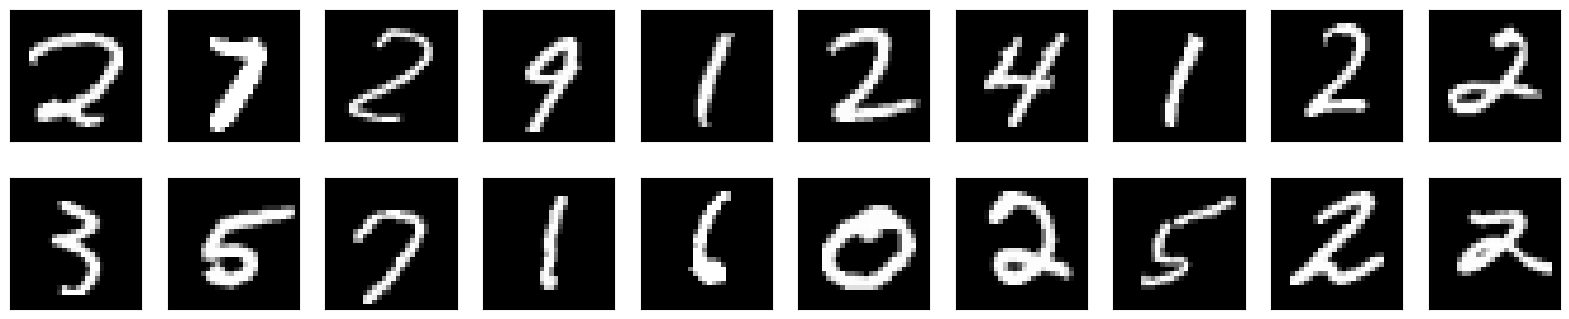

In [ ]:
plot_images(train_dataset.dataset.data[train_dataset.indices])

In [18]:
def linear_beta(t, start=0.0001, end=0.02):
    return torch.linspace(start, end, steps=t)

In [19]:
T = 300

def linear_beta(timesteps):
    return torch.linspace(1e-4, 0.02, timesteps)

betas = linear_beta(T)
alphas = 1.0 - betas
alphas_cumprod = torch.cumprod(alphas, dim=0)
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1.0 - alphas_cumprod)
alphas_cumprod_prev = torch.cat([torch.tensor([1.0]), alphas_cumprod[:-1]], dim=0)
sqrt_recip_alphas = torch.sqrt(1.0 / alphas)
posterior_variance = betas * (1.0 - alphas_cumprod_prev) / (1.0 - alphas_cumprod)

def forward_diffusion_sample(x_0, t, sqrt_alphas_cumprod, sqrt_one_minus_alphas_cumprod):
    '''
    Noise adding
    '''
    noise = torch.randn_like(x_0)
    sqrt_alphas_cumprod_t = sqrt_alphas_cumprod[t].view(-1, 1, 1, 1)
    sqrt_one_minus_alphas_cumprod_t = sqrt_one_minus_alphas_cumprod[t].view(-1, 1, 1, 1)
    x_t = sqrt_alphas_cumprod_t * x_0 + sqrt_one_minus_alphas_cumprod_t * noise
    return x_t, noise




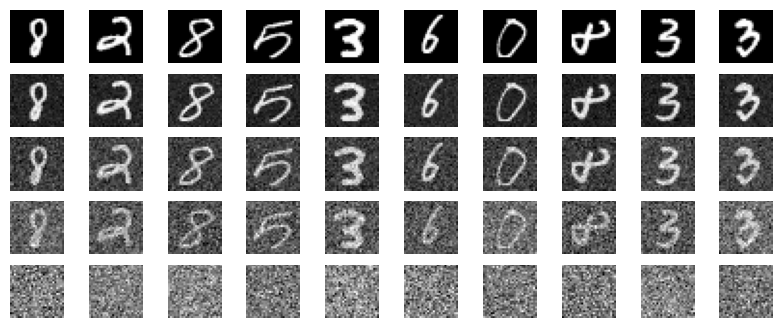

In [20]:
k = 1
for images, _ in train_loader:
    diffused_images1, _ = forward_diffusion_sample(images, torch.full((images.size(0),), 19), sqrt_alphas_cumprod, sqrt_one_minus_alphas_cumprod)
    diffused_images2, _ = forward_diffusion_sample(images, torch.full((images.size(0),), 49), sqrt_alphas_cumprod, sqrt_one_minus_alphas_cumprod)
    diffused_images3, _ = forward_diffusion_sample(images, torch.full((images.size(0),), 99), sqrt_alphas_cumprod, sqrt_one_minus_alphas_cumprod)
    diffused_images4, _ = forward_diffusion_sample(images, torch.full((images.size(0),), 299), sqrt_alphas_cumprod, sqrt_one_minus_alphas_cumprod)

    plt.figure(figsize=(10, 4))
    for i in range(10):
        for j, img in enumerate([images, diffused_images1, diffused_images2, diffused_images3, diffused_images4]):
            ax = plt.subplot(5, 10, i + 1 + j * 10)
            plt.imshow(img[i].detach().cpu().squeeze(), cmap='gray')
            ax.axis('off')
    plt.show()
    break


In [21]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Block(nn.Module):
    def __init__(self, in_ch, out_ch, up=False):
        super(Block, self).__init__()
        self.up = up
        self.conv1 = nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1)
        if up:
            self.transform = nn.ConvTranspose2d(out_ch, out_ch, kernel_size=3, stride=2, padding=1, output_padding=1)
        else:
            self.transform = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2 = nn.Conv2d(out_ch, out_ch, kernel_size=3, padding=1)
        self.bnorm1 = nn.BatchNorm2d(out_ch)
        self.bnorm2 = nn.BatchNorm2d(out_ch)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        h = self.bnorm1(self.relu(self.conv1(x)))
        h = self.bnorm2(self.relu(self.conv2(h)))
        h = self.transform(h)
        return h

class SimpleUnet(nn.Module):
    def __init__(self, input_channels=1, output_channels=1):
        super(SimpleUnet, self).__init__()

        down_channels = [64, 128, 256]
        up_channels = [256, 128, 64]

        self.conv0 = nn.Conv2d(input_channels, down_channels[0], kernel_size=3, padding=1)

        self.downs = nn.ModuleList([Block(down_channels[i], down_channels[i + 1], up=False) for i in range(len(down_channels) - 1)])

        self.ups = nn.ModuleList([Block(up_channels[i] * 2, up_channels[i + 1], up=True) for i in range(len(up_channels) - 1)])

        self.output_layer = nn.Conv2d(up_channels[-1], output_channels, kernel_size=1)

    def forward(self, x):

        x = self.conv0(x)

        residual_inputs = []
        for down in self.downs:
            x = down(x)
            residual_inputs.append(x)

        for up in self.ups:
            residual_x = residual_inputs.pop()
            x = torch.cat([x, residual_x], dim=1)
            x = up(x)

        return self.output_layer(x)


In [22]:
def get_loss(model, x_0, t, sqrt_alphas_cumprod, sqrt_one_minus_alphas_cumprod):
    x_noisy, noise = forward_diffusion_sample(x_0, t, sqrt_alphas_cumprod, sqrt_one_minus_alphas_cumprod)
    noise_pred = model(x_noisy)
    return F.mse_loss(noise_pred, noise)


In [23]:
input_channels = 1
output_channels = 1
model = SimpleUnet(input_channels=input_channels, output_channels=output_channels)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [24]:
def sample_timestep(x_0, sqrt_alphas_cumprod, sqrt_one_minus_alphas_cumprod, betas, sqrt_recip_alphas, posterior_variance, model):
    i = np.random.randint(0, x_0.shape[0])
    x_t, _ = forward_diffusion_sample(x_0, torch.full((x_0.shape[0],), T - 1), sqrt_alphas_cumprod, sqrt_one_minus_alphas_cumprod)

    plt.figure(figsize=(10, 4))
    for t in reversed(range(T)):
        t_batch = torch.full((x_0.shape[0],), t)
        noise_pred = model(x_t)

        betas_t = betas[t].view(1, 1, 1, 1)
        sqrt_recip_alphas_t = sqrt_recip_alphas[t].view(1, 1, 1, 1)
        sqrt_one_minus_alphas_cumprod_t = sqrt_one_minus_alphas_cumprod[t].view(1, 1, 1, 1)
        posterior_variance_t = posterior_variance[t].view(1, 1, 1, 1)

        x_t_1 = sqrt_recip_alphas_t * (x_t - betas_t * noise_pred / sqrt_one_minus_alphas_cumprod_t)

        if t == 0:
            ax = plt.subplot(1, 5, 5)
            plt.imshow(x_t_1[i].detach().cpu().squeeze(), cmap='gray')
            ax.axis('off')
            return x_t_1
        else:
            noise = torch.randn_like(x_t)
            x_t_1 = x_t_1 + torch.sqrt(posterior_variance_t) * noise

        if t in [299, 99, 49, 19]:
            ax = plt.subplot(1, 5, [299, 99, 49, 19].index(t) + 1)
            plt.imshow(x_t_1[i].detach().cpu().squeeze(), cmap='gray')
            ax.axis('off')

        x_t = x_t_1
    plt.show()
    return x_t


In [29]:
def test(model, test_loader):
    fid = FrechetInceptionDistance(feature=2048).to(device)
    model.eval()


    with torch.no_grad():
        for batch in test_loader:
            if isinstance(batch, (list, tuple)):
                real = batch[0]
            else:
                real = batch

            real = real.to(device)
            fake = sample_timestep(
                real,
                sqrt_alphas_cumprod,
                sqrt_one_minus_alphas_cumprod,
                betas,
                sqrt_recip_alphas,
                posterior_variance,
                model
            )

            if real.shape[1] == 1: #RGB
                real = real.repeat(1, 3, 1, 1)
                fake = fake.repeat(1, 3, 1, 1)

            #[-1, 1] → [0, 1]
            real = (real + 1) / 2
            fake = (fake + 1) / 2

            real = torch.clamp(real, 0, 1)
            fake = torch.clamp(fake, 0, 1)

            real = (real * 255).to(torch.uint8)
            fake = (fake * 255).to(torch.uint8)

            fid.update(real, real=True)
            fid.update(fake, real=False)


    fid_score = fid.compute()

    print(f"FID score: {fid_score:.4f}")


In [26]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
epochs = 50
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
train_losses = []
val_losses = []

best_val_loss = float('inf')
patience = 5
counter = 0

for epoch in range(epochs):
    model.train()
    train_loss = 0
    for step, batch in enumerate(train_loader):
        x = batch[0].to(device)
        t = torch.randint(0, T, (x.shape[0],), device=device).long()
        loss = get_loss(model, x, t, sqrt_alphas_cumprod, sqrt_one_minus_alphas_cumprod)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_loss /= len(train_loader)
    train_losses.append(train_loss)

    model.eval()
    val_loss = 0
    with torch.no_grad():
        for val_batch in val_loader:
            x = val_batch[0].to(device)
            t = torch.randint(0, T, (x.shape[0],), device=device).long()
            loss = get_loss(model, x, t, sqrt_alphas_cumprod, sqrt_one_minus_alphas_cumprod)
            val_loss += loss.item()
    val_loss /= len(val_loader)
    val_losses.append(val_loss)

    print(f"Epoch {epoch} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        counter = 0
        torch.save(model.state_dict(), "/content/drive/MyDrive/Colab Notebooks/best_model.pt")

    else:
        counter += 1
        if counter >= patience:
            print(f"Early stopping triggered after {epoch + 1} epochs.")
            break



Epoch 0 | Train Loss: 0.2822 | Val Loss: 0.1465
Epoch 1 | Train Loss: 0.1224 | Val Loss: 0.1182
Epoch 2 | Train Loss: 0.1027 | Val Loss: 0.1011
Epoch 3 | Train Loss: 0.0932 | Val Loss: 0.0990
Epoch 4 | Train Loss: 0.0854 | Val Loss: 0.0871
Epoch 5 | Train Loss: 0.0819 | Val Loss: 0.0823
Epoch 6 | Train Loss: 0.0801 | Val Loss: 0.0870
Epoch 7 | Train Loss: 0.0764 | Val Loss: 0.0764
Epoch 8 | Train Loss: 0.0741 | Val Loss: 0.0767
Epoch 9 | Train Loss: 0.0712 | Val Loss: 0.0727
Epoch 10 | Train Loss: 0.0697 | Val Loss: 0.0748
Epoch 11 | Train Loss: 0.0688 | Val Loss: 0.0691
Epoch 12 | Train Loss: 0.0680 | Val Loss: 0.0698
Epoch 13 | Train Loss: 0.0662 | Val Loss: 0.0667
Epoch 14 | Train Loss: 0.0652 | Val Loss: 0.0662
Epoch 15 | Train Loss: 0.0648 | Val Loss: 0.0654
Epoch 16 | Train Loss: 0.0634 | Val Loss: 0.0686
Epoch 17 | Train Loss: 0.0634 | Val Loss: 0.0702
Epoch 18 | Train Loss: 0.0626 | Val Loss: 0.0655
Epoch 19 | Train Loss: 0.0622 | Val Loss: 0.0639
Epoch 20 | Train Loss: 0.0610 

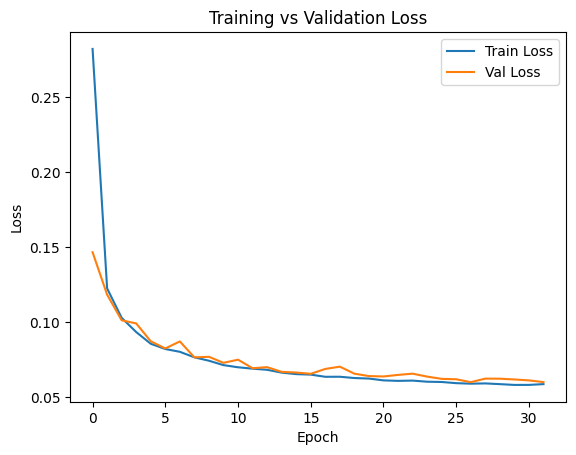

In [27]:
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Training vs Validation Loss")
plt.show()


FID score: 24.6031


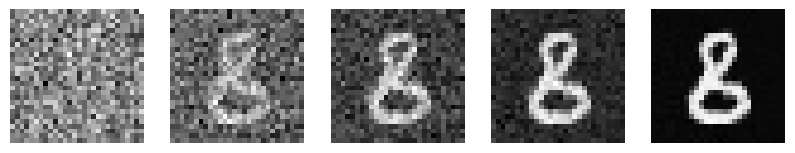

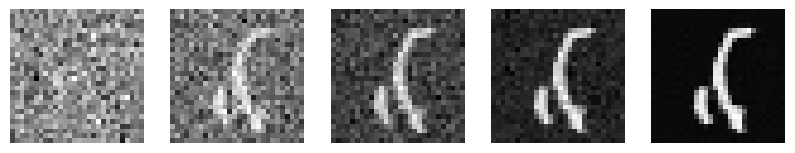

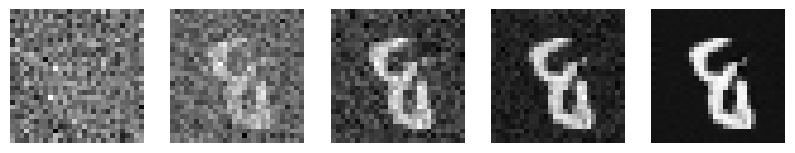

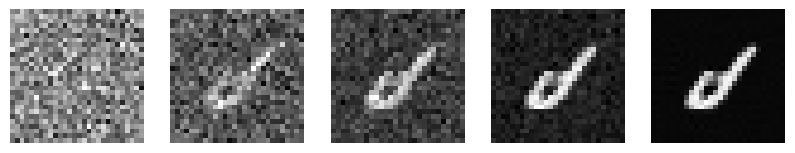

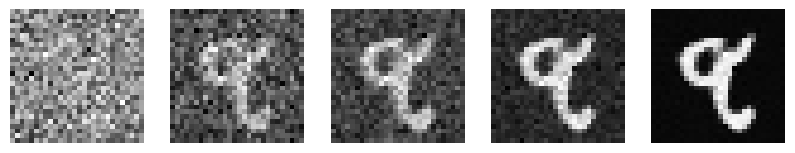

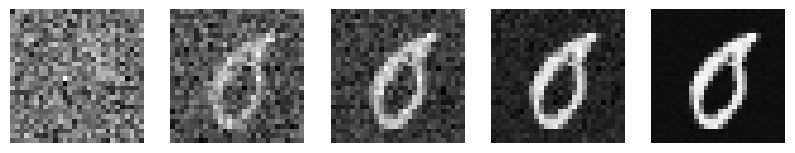

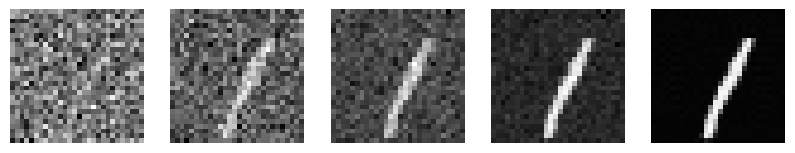

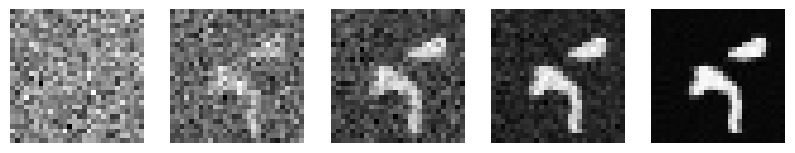

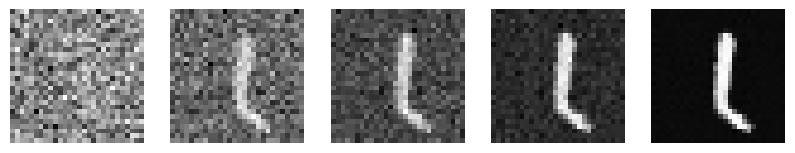

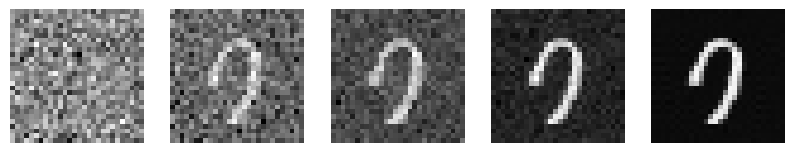

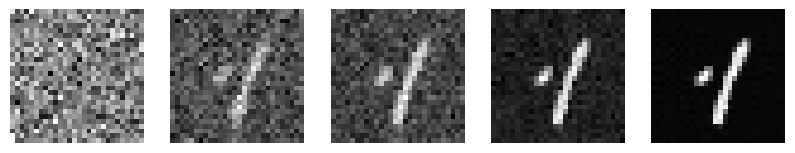

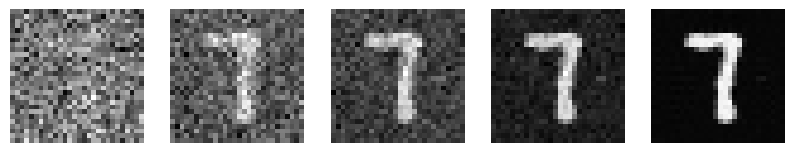

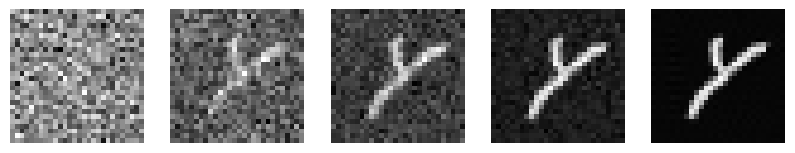

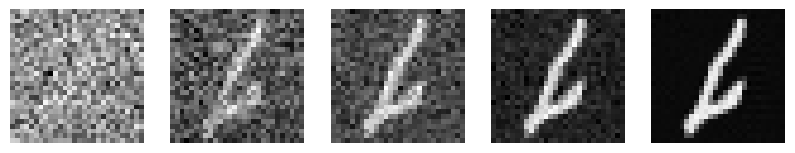

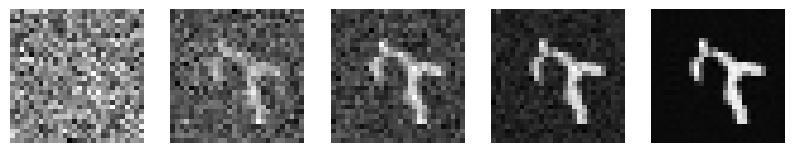

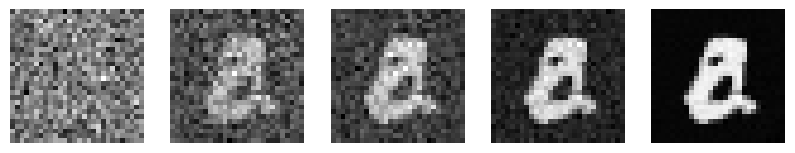

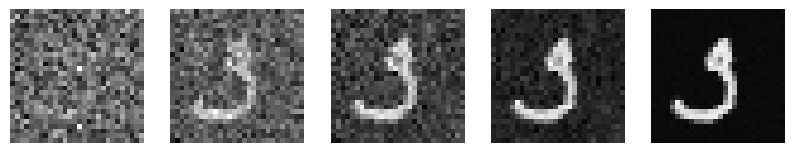

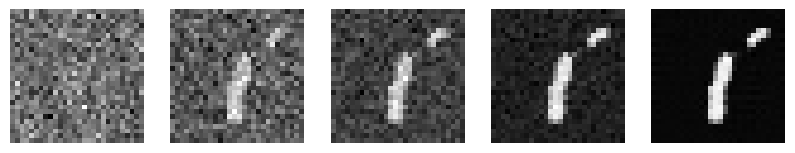

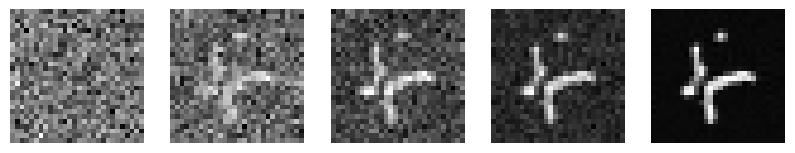

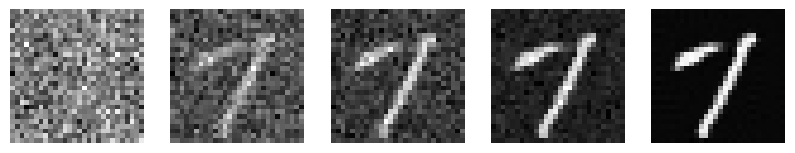

In [30]:
from torchmetrics.image.fid import FrechetInceptionDistance
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.load_state_dict(torch.load("/content/drive/MyDrive/Colab Notebooks/best_model.pt"))
model.to(device)
test(model, test_loader)
